# 02 area perturbation

Within the following tutorial you are going to see how to perturb one area of a graph. Perturbing an entire area means perturbing all the nodes contained in that area.

### Input description

The input for the graph construction currently consists of text files reflecting the hierarchy of the plant elements and their features. In the text input files each line corresponds to a node/element description.
The same line reports the name of the predecessor of a particular node/element, the relationship between them, and the list of node’s attributes (area in which the element is 
present, perturbation resistance, etc.).
In this way each line corresponds to an edge connecting a element to its parent element.

Each line should contain the following info:
- element id (**mark**)
- parent-child relationship (**father_condition**: *AND*, *OR*, *SINGLE*, *ORPHAN*. It is an edge attribute.)
- id of the parent of the element (**father_mark**)
- area in which the element is located (**area**. It is a node attribute.)
- passive perturbation resistance (**perturbation_resistant**: *1*, *0*. It is a node attribute.)
- state of the SWITCH(es) (**init_status**: *1*, *0*. It is a node attribute.)
- description of the element (**description**. It is a node attribute.)
- source - hub - switch- user elements (**type**: *SOURCE* or *HUB* or *SWITCH* or *USER*. It is a node attribute.)
- weight of the edge between element and parent (**weight**: float number. It is an edge attribute.)
- initial service at the sources (**initial_service**. It is a node attribute, for the moment valid just for sources, and 0. for other nodes. It is a node attribute.)

The hierarchy of the elements explains how commodities flow from one element to another element and from one system to another system. In fact, if the input is properly formatted, with this simple digraph model it is possible to represent and integrate different interconnected plants in a unique graph without losing information about their peculiarities. 

In the graph, the nodes represent the system elements while the edges connecting the nodes harbor the logic relations (edge attributes) existing between the elements (*ORPHAN*, *SINGLE*, *AND*, and *OR*):
- An **ORPHAN** edge is the edge of a node without predecessors.
- A **SINGLE** edge connects a node to its only one predecessor.
- An **AND** edge indicates that the node/element has more than one predecessor. All the predecessors are necessary for the functioning of that element.
- An **OR** edge indicates that the node/element has more than one predecessor. Just one of the node’s predecessors should be active to guarantee the functioning of the element. For this reason, correct input formatting is one of the most important steps of the analysis.

### The TOY graph

Let us see how to generate a perturbation that propagates from element "1" of the TOY graph. First of all, we need to import GRAPE classes. We are also importing pandas package since we are going to use it for reading the CSV output files obtained.

In [1]:
import pandas as pd
from grape.general_graph import GeneralGraph
from grape.fault_diagnosis import FaultDiagnosis
%matplotlib inline
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


Second of all, we define a FaultDiagnosis class and we load the nodes for the TOY graph from the input file.

In [2]:
F = FaultDiagnosis("./input_files/TOY_graph.csv")

Let's have a look at the graph we are going to study.

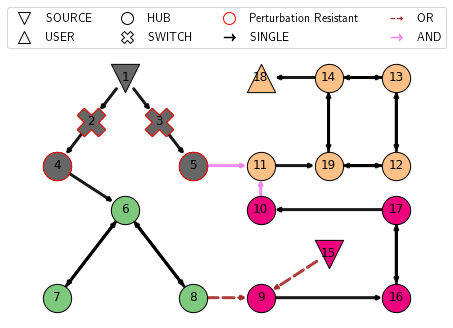

In [3]:
initial = { '11': (2., 2.), '19': (6., 2.), '12': (10., 2.),
    '14': (6., 10.), '13': (10., 10.), '18': (2., 10.), '5': (-2., 2.),
    '3': (-4., 6.), '1': (-6., 10.), '2': (-8., 6.), '4': (-10., 2.),
    '6': (-6., -2.), '7': (-10, -10.), '8': (-2, -10.), '10': (2., -2.),
    '17': (10., -2.), '16': (10., -10.), '9': (2., -10.), '15': (6., -6.)}

F.G.print_graph(initial_pos=initial, size=800, edge_width=3., arrow_size=7, fsize=12,
                fixed_nodes=list(F.G), title='TOY graph (integer)', input_cmap='Accent',
                legend_loc='upper center', legend_ncol=4, legend_anchor=(0.5, 1.2),
                legend_fsize=12)

In the figure above it is represented the example input file `TOY_graph.csv`.
In this file are present 19 nodes/elements connected by direct edges that reflect the hierarchy of the system in a parent-child fashion.

The nodes are distributed in adjacent areas, which have been depicted with different colors specifying the `input_cmap` argument of `print_graph` function.

In area1 are present 5 nodes: 1, 2, 3, 4 and 5.

In area2 are present 6 nodes: 11, 19, 12, 13, 14 and 18.

In area3 are present 5 nodes: 15, 9, 16, 17 and 10.

In area4 are present 3 nodes: 6, 7 and 8.

A perturbation of one or multiple elements in one area may exceed the area boundaries and propagate to other systems connected to it, located in other areas. 

Nodes 2, 3, 4, 5 are perturbation resistant nodes (`perturbation_resistant` field = 1).
These nodes will not be affected by the simulated perturbation.

Nodes 2 and 3 are isolating elements (they are a particular type of `HUB` nodes, called `SWITCH`). In the figure, perturbing node 1 would result in the breakage of all the nodes present in the graph except 
node 15 in absence of perturbation resistant nodes. On the other hand, isolating elements 2 and 3 would stop the perturbation propagation cascade to node 1.

### Simulate a perturbation to "area1"

Let us check the input before perturbing the graph in any way. In order to do so we use `check_input_with_gephi` function, which prints out the list of edges and the list of nodes of the current graph. The two output files generated can be used to visualize the input with Gephi.

In [4]:
F.check_input_with_gephi()

Let us have a look at the list of nodes and edges that get printed for the integer TOY graph.

In [5]:
nodes = pd.read_csv("check_import_nodes.csv", na_filter=False)
nodes

,mark,description,init_status,perturbation_resistant,area
0,1,,,0,area1
1,2,,1,1,area1
2,3,,1,1,area1
3,4,,,1,area1
4,5,,,1,area1
5,6,,,0,area4
6,7,,,0,area4
7,8,,,0,area4
8,9,,,0,area3
9,15,,,0,area3


In [6]:
edges = pd.read_csv("check_import_edges.csv", na_filter=False)
edges

,mark,father_mark
0,2,1
1,3,1
2,4,2
3,5,3
4,6,4
5,6,7
6,7,6
7,8,6
8,6,8
9,9,8


### Perturb an area

In order to perturb an area, we are going to use the function `simulate_area_perturbation`, which takes as an argument the list of the areas that we want to damage.

In [7]:
F.simulate_area_perturbation(["area1"])

DEBUG:root:In the graph are present 19 nodes
DEBUG:root:The graph is dense, density = 0.07894736842105263
DEBUG:root:BEST: {'2': True, '3': True}, with fitness: -20.0
DEBUG:root:Visited: {'1'}
DEBUG:root:Node: 1
DEBUG:root:Predecessors: []
DEBUG:root:Broken: ['1']
DEBUG:root:Visited: {'1', '2'}
DEBUG:root:Node: 2
DEBUG:root:Node 2 visited, fault resistant node
DEBUG:root:Visited: {'1', '3', '2'}
DEBUG:root:Node: 3
DEBUG:root:Node 3 visited, fault resistant node
DEBUG:root:Visited: {'2'}
DEBUG:root:Node: 2
DEBUG:root:Node 2 visited, fault resistant node
DEBUG:root:Visited: {'3'}
DEBUG:root:Node: 3
DEBUG:root:Node 3 visited, fault resistant node
DEBUG:root:Visited: {'4'}
DEBUG:root:Node: 4
DEBUG:root:Node 4 visited, fault resistant node
DEBUG:root:Visited: {'5'}
DEBUG:root:Node: 5
DEBUG:root:Node 5 visited, fault resistant node
DEBUG:root:In the graph are present 18 nodes
DEBUG:root:The graph is dense, density = 0.08169934640522876


/u/m/mteruzzi/miniconda/envs/test/lib/python3.6/site-packages/grape-1.1.0-py3.6.egg/grape/fault_diagnosis.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  params, weights, parallel))


The execution of the area perturbation gives us information about what is going on.
The size of the integer graph is reported (19 nodes), and depending on the graph density different methods for shortest path calculation are adopted. In particular, for dense graphs like the one in this tutorial, Floyd-Warshall algorithm is adopted.

The debug output gives us an idea of what happens when a node is perturbed. Node 1 has no fault resistance of any kind; hence, it gets broken. After that, the perturbation gets propagated on all neighboring nodes, namely nodes 2 and 3 in our case. They are visited, but not affected by the damage, being fault resistant.

Since node 2 and 3 are fault resistant, the best state identified for the switches by the genetic algorithm is still the one with switches closed, since it implies the smallest number of manual actions with respect to the initial condition. We are going to give a more detailed explanation on switches activation on a later tutorial.

We can have a look at the final configuration using the function `print_graph`. The graph is missing node `1`, which has been broken.

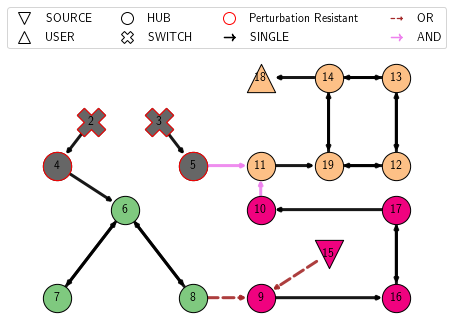

In [8]:
F.G.print_graph(initial_pos=initial, size=800, edge_width=3., arrow_size=7, fsize=12,
                fixed_nodes=list(F.G), title='TOY graph (perturbed)', input_cmap='Accent',
                legend_loc='upper center', legend_ncol=4, legend_anchor=(0.5, 1.2),
                legend_fsize=12)

### Output

The simulation of the damage generates a few output files, which give us a diagnostics of the fault that just happened.

Output file `area_perturbation.csv` lists the new status of the elements (active, not-active) and the areas in which the elements are located (affected, not affected) as well as the new status of elements that have been operated to stop the propagation of the perturbation or to open new paths in case of unavailabilty of the default ones. 
The efficiency (*nodal efficiency*, *local efficiency*, *global efficiency*) and closeness indices (*closeness_centrality*, *betweenness_centrality*, *indegree_centrality*) are then recalculated.

In [9]:
area = pd.read_csv("area_perturbation.csv", na_filter=False)
area

,mark,description,init_status,final_status,mark_status,perturbation_resistant,area,status_area,original_closeness_centrality,final_closeness_centrality,...,original_indegree_centrality,final_indegree_centrality,original_outdegree_centrality,final_outdegree_centrality,original_local_efficiency,final_local_efficiency,original_nodal_efficiency,final_nodal_efficiency,original_service,final_service
0,1,,,,NOT_ACTIVE,0,area1,DAMAGED,0.000000,,...,0.000000,,0.111111,,0.174374,,0.321362,,0.0,
1,2,,1,1,ACTIVE,1,area1,DAMAGED,0.055556,0.0,...,0.055556,0.0,0.055556,0.058823529411764705,0.202227,0.21412231559290384,0.196896,0.20847763347763348,0.0,0.0
2,3,,1,1,ACTIVE,1,area1,DAMAGED,0.055556,0.0,...,0.055556,0.0,0.055556,0.058823529411764705,0.148148,0.1568627450980392,0.151852,0.1607843137254902,0.0,0.0
3,4,,,,ACTIVE,1,area1,DAMAGED,0.074074,0.058823529411764705,...,0.055556,0.058823529411764705,0.055556,0.058823529411764705,0.225838,0.2391223155929038,0.202227,0.21412231559290384,0.0,0.0
4,5,,,,ACTIVE,1,area1,DAMAGED,0.074074,0.058823529411764705,...,0.055556,0.058823529411764705,0.055556,0.058823529411764705,0.148148,0.15686274509803924,0.148148,0.1568627450980392,0.0,0.0
5,6,,,,ACTIVE,0,area4,AVAILABLE,0.173611,0.18823529411764706,...,0.166667,0.17647058823529413,0.111111,0.11764705882352941,0.211828,0.22428804855275447,0.225838,0.2391223155929038,0.0,0.0
6,7,,,,ACTIVE,0,area4,AVAILABLE,0.115741,0.11764705882352941,...,0.055556,0.058823529411764705,0.055556,0.058823529411764705,0.225838,0.2391223155929038,0.174449,0.18471055088702149,0.0,0.0
7,8,,,,ACTIVE,0,area4,AVAILABLE,0.115741,0.11764705882352941,...,0.055556,0.058823529411764705,0.111111,0.11764705882352941,0.193541,0.2049253034547152,0.249206,0.26386554621848746,0.0,0.0
8,9,,,,ACTIVE,0,area3,AVAILABLE,0.143275,0.15126050420168066,...,0.111111,0.11764705882352941,0.055556,0.058823529411764705,0.156481,0.16568627450980392,0.161243,0.1707282913165266,0.0,0.0
9,15,,,,ACTIVE,0,area3,AVAILABLE,0.000000,0.0,...,0.000000,0.0,0.055556,0.058823529411764705,0.161243,0.1707282913165266,0.165873,0.17563025210084032,0.0,0.0


There is a lot of information contained in this output file. We would like to focus on some.
The status of the nodes contained in `mark_status` and `status_area` reflect the consequences of the damage: broken nodes are defined as `NOT_ACTIVE`, while areas that contain broken nodes are labeled as `DAMAGED`.

In [10]:
area[['mark_status', 'status_area']]

,mark_status,status_area
0,NOT_ACTIVE,DAMAGED
1,ACTIVE,DAMAGED
2,ACTIVE,DAMAGED
3,ACTIVE,DAMAGED
4,ACTIVE,DAMAGED
5,ACTIVE,AVAILABLE
6,ACTIVE,AVAILABLE
7,ACTIVE,AVAILABLE
8,ACTIVE,AVAILABLE
9,ACTIVE,AVAILABLE


Moreover, the nodes in the GeneralGraph are labeled as *SOURCE*, *HUB* or *USER*, and commodities flow from *SOURCE* to *USER*, passing through *HUB* nodes. In order to better understand this concept, let us load another output file generated by the perturbation simulation, `service_paths_area_perturbation.csv`, which reports the paths (all paths and shortest paths), if any, that connect *SOURCE* and *USER* elements (paths are calculated before and after perturbing one or multiple elements).

In [11]:
paths = pd.read_csv("service_paths_area_perturbation.csv", na_filter=False)
paths

,from,area,to,original_shortest_path_length,original_shortest_path,original_simple_path,original_pair_efficiency,ids,final_shortest_path_length,final_shortest_path,final_simple_path,final_pair_efficiency
0,1,area1,18,6.0,"['1', '3', '5', '11', '19', '14', '18']","[['1', '2', '4', '6', '8', '9', '16', '17', '1...",0.166667,118,,,,
1,15,area3,18,8.0,"['15', '9', '16', '17', '10', '11', '19', '14'...","[['15', '9', '16', '17', '10', '11', '19', '12...",0.125000,1518,8.0,"['15', '9', '16', '17', '10', '11', '19', '14'...","[['15', '9', '16', '17', '10', '11', '19', '12...",0.125


Since node 1 is broken, there is no final path between node 1 and node 18, while it still exists between nodes 15 and 18. Due to the damage of node 1, we can also see that the total final service at the *USER* 18 is smaller than the original one, lowered by 1 which is the service granted by the *SOURCE* represented by node 1, which is no more available.

In [12]:
area[['original_service', 'final_service']].loc[18]

original_service      3
final_service       2.0
Name: 18, dtype: object